In [2]:
from google.colab import drive
drive.flush_and_unmount()

Drive not mounted, so nothing to flush and unmount.


In [3]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [4]:
%cd /content/drive/MyDrive/Colab Notebooks/기계시스템설계/23년/baseline0724

/content/drive/MyDrive/Colab Notebooks/기계시스템설계/23년/baseline0724


In [5]:
!pip install fmpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.6/111.6 kB 12.1 MB/s eta 0:00:00


In [ ]:
!pip install wandb

In [ ]:
!wandb login --relogin

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [6]:
from fmpy import read_model_description, extract
from fmpy.fmi2 import FMU2Slave
from fmpy.util import plot_result, download_test_file
import numpy as np
import pandas as pd
import shutil
import matplotlib.pyplot as plt
import wandb

import random
import numpy as np
import torch
import argparse
import os
import sys
import numpy as np
import tensorflow as tf
from tensorflow import keras

from collections import deque
import numpy as np
from tqdm import tqdm

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import scipy.signal
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.normal import Normal
from torch import FloatTensor as FT

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
from torch.utils.tensorboard import SummaryWriter

In [7]:
fmu_filename = 'HEV_TMED_Simulator_Rearrange_230711_linux.fmu'
# HWFET / JN1015 / UDDS profile에 대하여 시험
with open("wltp_vehicle_speed_profile_real.csv") as file_name:
  wltp = np.loadtxt(file_name, delimiter=",")
with open("hwfet.csv") as file_name:
  hwfet = np.loadtxt(file_name, delimiter=",")
with open("jn1015.csv") as file_name:
  jn1015 = np.loadtxt(file_name, delimiter=",")
with open("udds.csv") as file_name:
  udds = np.loadtxt(file_name, delimiter=",")
with open("nedc.csv") as file_name:
  nedc = np.loadtxt(file_name, delimiter=",")

# plt.figure(figsize = (5,25))
# plt.subplot(5,1,1)
# plt.title('wltp')
# plt.plot(wltp[:,1])
# plt.subplot(5,1,2)
# plt.title('hwfet')
# plt.plot(hwfet[:,1])
# plt.subplot(5,1,3)
# plt.title('jn1015')
# plt.plot(jn1015[:,1])
# plt.subplot(5,1,4)
# plt.title('udds')
# plt.plot(udds[:,1])
# plt.subplot(5,1,5)
# plt.title('nedc')
# plt.plot(nedc[:,1])
# plt.show()

In [ ]:
# fmu_filename = 'HEV_TMED_Simulator_Rearrange_230711_linux.fmu'
# HWFET / JN1015 / UDDS profile에 대하여 시험
with open("wltp_vehicle_speed_profile_real.csv") as file_name:
  wltp = np.loadtxt(file_name, delimiter=",")
with open("hwfet.csv") as file_name:
  hwfet = np.loadtxt(file_name, delimiter=",")
with open("jn1015.csv") as file_name:
  jn1015 = np.loadtxt(file_name, delimiter=",")
with open("udds.csv") as file_name:
  udds = np.loadtxt(file_name, delimiter=",")
with open("nedc.csv") as file_name:
  nedc = np.loadtxt(file_name, delimiter=",")

cyclename = ['WLTP', 'HWFET', 'JN1015', 'UDDS', 'NEDC']
cyclelist = [wltp, hwfet, jn1015, udds, nedc]


    # wandb.log({"HWFET":vehicle_speed_profile[step,1]})
    # wandb.log({"HWFET":reward})

for i in range(len(cyclename)):
  vehicle_speed_profile = cyclelist[i]
  run = wandb.init(project = "cycle plot",
                  reinit=True)
  wandb.run.name = 'cycle {}'.format(cyclename[i])
  for j in range(len(cyclelist[i])):
    # print(j)
    wandb.log({cyclename[i]:vehicle_speed_profile[j,1]})
    # print(cyclelist[i][j,1])


cycle,▂▁▃▃▂▄▁▁▁▃▁▃▃▁▂▂▃▁▄▃▁▁▃▁▃▃▁▁▄▅▅▄▄▄▅▅▇▇█▁
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
cycle,0.0
step,1181


WLTP,▂▂▁▂▂▄▃▃▂▂▁▁▂▂▄▂▃▄▄▅▄▂▁▃▄▂▆▆▅▅▄▃▁▄▆▇▇█▆▂
WLTP,0.0


HWFET,▂▅▅▆▆▇▇▆▆▆▆▆▆▇▆▄▆▇███████▇▇██▇▇▇▇▇▇▇▇█▇▁
HWFET,0.0


JN1015,▁▁▁▃▆▇█▆█▅▁▁▁▃▁▅▄▃▁▃▁▅▄▃▁▃▁▅▃▂▁▁▂▆▆▇▇█▆▁
JN1015,0.0


UDDS,▁▄▄▅▁▄▇██▅▃▆▅▆▅▄▁▃▁▄▃▃▁▅▅▅▄▄▅▄▁▅▁▂▂▄▁▄▂▃
UDDS,0.0


In [ ]:
import numpy as np
import wandb
cycle_name = ["HWFET", "JN1015", "UDDS","NEDC", "WLTP"]
ep_reward_list = np.load("eprewardlist.npy")

for i in range(ep_reward_list.shape[0]):
  run = wandb.init(project = "Cycle test",
                  reinit=True)
  wandb.run.name = cycle_name[i]
  for j in range(ep_reward_list.shape[1]):
    wandb.log({ "Step": j+1,"Episodic reward": ep_reward_list[i,j]})

40.0

In [8]:
class HEV:
    def __init__(self, fmu_filename, start_time, stop_time, step_size, soc_init, vehicle_speed_profile):
        self.fmu_filename = fmu_filename
        self.vrs = {}
        self.start_time = start_time
        self.stop_time = stop_time
        self.step_size = step_size
        self.time = self.start_time
        self.vehicle_speed_profile = vehicle_speed_profile
        self.soc_init = soc_init/5000
        self.soc_base = soc_init/5000
        self.state_init = np.array([self.soc_init, 0, 0]).reshape(1,-1)
        self.state = np.array([self.soc_init, 0, 0]).reshape(1,-1)
        self.action_upper_bound = 15000
        self.action_lower_bound = -15000
        #self.action_space = [[13500, 2000], [500, 2000], [13500, -15000], [500, -15000]]
        self.obssize = len(self.state[0])
        self.actsize = 2

        model_description = read_model_description(self.fmu_filename)
        for variable in model_description.modelVariables:
            self.vrs[variable.name] = variable.valueReference
        unzipdir = extract(fmu_filename)
        self.fmu = FMU2Slave(guid=model_description.guid,
                       unzipDirectory=unzipdir,
                       modelIdentifier=model_description.coSimulation.modelIdentifier,
                       instanceName='instance1')

    def step(self, action):
        #a = self.action_space[action]
#         action = action*self.action_upper_bound
        a1 = action[0]*self.action_upper_bound
        a2 = action[0]*self.action_upper_bound
        a3 = self.soc_init*5000
        a4 = action[1]/2 + 1
        instant_veh_speed = np.interp(self.time, self.vehicle_speed_profile[:,0], self.vehicle_speed_profile[:,1])
        self.fmu.setReal([self.vr_input1, self.vr_input2, self.vr_input3, self.vr_input4, self.vr_input5], [instant_veh_speed, a1, a2, a3, a4]) #input variable, input key(13500 2000)
        self.fmu.doStep(currentCommunicationPoint=self.time, communicationStepSize=self.step_size)
#         [output1, output2, output3, output4, output5, output6, output7] = self.fmu.getReal([self.vr_output1,self.vr_output2, self.vr_output3, self.vr_output4, self.vr_output5, self.vr_output6, self.vr_output7])
#         self.state = [output1, output2, output3, output4, output5, output6, output7]
        state = np.array(self.fmu.getReal(np.arange(35)))/5000
        state_column = np.array([self.vrs['Bat_SOC'], self.vrs['BSFC_g_kWh[1]'], self.vrs['Driver_sVeh_kph']])
        self.state = state[state_column]
        soc = state[self.vrs['Bat_SOC']]
        BSFC = state[self.vrs['BSFC_g_kWh[1]']]
        reward = 1 - 10000*(self.soc_init - soc) ** 2 - BSFC
        is_done = lambda time: time >= self.stop_time
        info = state[np.array([self.vrs['Bat_SOC'], self.vrs['nEngOn'], self.vrs['PT_tqTmInDmd_Nm_P2'], self.vrs['ObEng_nEng_Rpm'], self.vrs['TrEtp_tqEngMAF_Nm'], self.vrs['TrP0_tqP0_Nm'], self.vrs['TrP2_tqP2_Nm'], self.vrs['Driver_sVeh_kph'], self.vrs['BSFC_g_kWh[1]']])]
        self.time += self.step_size
        return self.state.reshape(1,-1), reward, is_done(self.time), info

    def reset(self):

        self.fmu.instantiate()
        self.fmu.setupExperiment(startTime=self.start_time)
        self.fmu.enterInitializationMode()
        self.fmu.exitInitializationMode()
        self.state = self.state_init
        self.time = self.start_time

        self.vr_input1 = self.vrs['Driver_sVeh_Target_kph']
        self.vr_input2 = self.vrs['Engine_on_line']
        self.vr_input3 = self.vrs['Engine_off_line']
        self.vr_input4 = self.vrs['soc_init']
        self.vr_input5 = self.vrs['Engine_OOL']
        self.vr_output1 = self.vrs['TgMod_fPt']
        self.vr_output2 = self.vrs['P2_wElec_W']
        self.vr_output3 = self.vrs['P4_wElec_W']
        self.vr_output4 = self.vrs['ObP2_wElecBIntv_W']
        self.vr_output5 = self.vrs['EV_on_line']
        self.vr_output6 = self.vrs['EV_off_line']
        self.vr_output7 = self.vrs['Bat_SOC']
        self.vr_output8 = self.vrs['PT_tqTmInDmd_Nm_P2']
        self.vr_output9 = self.vrs['P0_wElec_W']
        self.vr_output10 = self.vrs['Pwr_Aux_W']
        self.vr_output11 = self.vrs['ObEng_nEng_Rpm']
        self.vr_output12 = self.vrs['TrEtp_tqEngMAF_Nm']
        self.vr_output13 = self.vrs['rpm_P0']
        self.vr_output14 = self.vrs['TM_F_nTmIn_rpm']
        self.vr_output15 = self.vrs['TM_R_nTmIn_rpm']
        self.vr_output16 = self.vrs['eBat_kWh']
        self.vr_output17 = self.vrs['nEngOn']
        self.vr_output18 = self.vrs['TrP0_tqP0_Nm']
        self.vr_output19 = self.vrs['TrP2_tqP2_Nm']
        self.vr_output20 = self.vrs['TrP4_tqP4_Nm']
        self.vr_output21 = self.vrs['TCU_F_fCurGe']
        self.vr_output22 = self.vrs['TCU_F_fTarGe']
        self.vr_output23 = self.vrs['Driver_sVeh_kph']
        self.vr_output24 = self.vrs['Eng_eff_avg']
        self.vr_output25 = self.vrs['TM_F_P0P2_eff_avg']
        self.vr_output26 = self.vrs['TM_F_P0P4_eff_avg']
        self.vr_output27 = self.vrs['BSFC_g_kWh[1]']
        self.vr_output28 = self.vrs['BSFC_g_kWh[2]']
        self.vr_output29 = self.vrs['BSFC_g_kWh[3]']

        return self.state.reshape(1,-1)

In [ ]:
import math
state1_num = 20
state2_num = 7
action_num = 16**2

state_num_ = 100

SOC_interval = np.arange(0,20) * 0.001 # SOC 5% 간격
Vel_interval = np.arange(0,6)*20/5000  # velocity 20km/h 간격

SOC_interval_ = np.arange(0,100) * 1/5000 # SOC 5% 간격

def state_index(state1, state2): # SOC, Velocity
  s1, s2 = 0,0
  # s1 = 0
  for i in range(len(SOC_interval)):
    if SOC_interval[i] < state1:
      s1+=1
  for i in range(len(Vel_interval)):
    if Vel_interval[i] < state2:
      s2+=1
  return s1, s2

def state_index_(state): # SOC
  s = 0
  for i in range(len(SOC_interval_)):
    if SOC_interval_[i] < state:
      s+=1
  return s

action_grid = []
for i in np.linspace(-1,1,int(math.sqrt(action_num))):
  for j in np.linspace(-1,1,int(math.sqrt(action_num))):
    action_grid.append([i,j])

In [9]:
num_states, num_actions = 3, 2
# upper_bound = env.action_upper_bound/env.action_upper_bound
# lower_bound = env.action_lower_bound/env.action_upper_bound

In [10]:
last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)
# policy network (mean, logstd)
def get_actor():
    # Initialize weights between -3e-3 and 3-e3
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(256, activation="relu")(inputs)
    out = layers.Dense(256, activation="relu")(out)
    mean_out = layers.Dense(num_actions, kernel_initializer=last_init)(out)
    log_std_out = layers.Dense(num_actions, kernel_initializer=last_init)(out)

    # outputs = outputs * upper_bound
    model = tf.keras.Model(inputs, [mean_out, log_std_out])
    return model

# SAC github 참고
epsilon = 1e-6
LOG_SIG_MIN = -4
LOG_SIG_MAX = 2
def policy(state, actor):
    mean, log_std = actor(state)
    log_std = tf.clip_by_value(log_std, LOG_SIG_MIN, LOG_SIG_MAX)
    std = tf.exp(log_std)
    normal = tfp.distributions.Normal(mean, std)
    x_t = normal.sample()
    y_t = tf.tanh(x_t)
    action = y_t
    log_prob = normal.log_prob(x_t)
    log_prob = -tf.math.log((1-y_t**2)+epsilon)
    log_prob = tf.reduce_sum(log_prob, axis = 1, keepdims=True)
    mean = tf.tanh(mean)
    return action, log_prob, mean

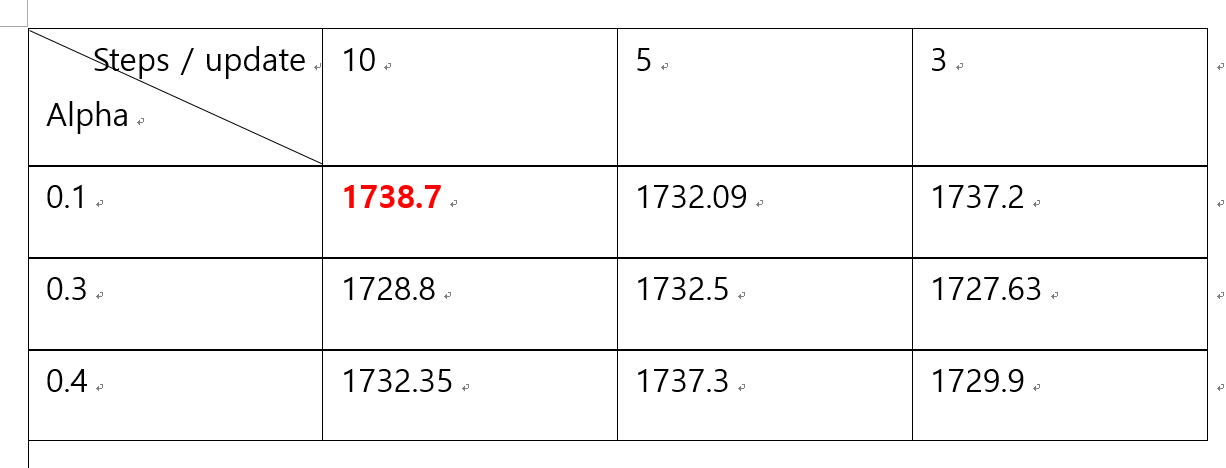

In [1]:
import pandas as pd
import seaborn as sns

reward_1 = [1738.7, 1732.1, 1732.2]
reward_3 = [1728.8, 1732.5, 1727.6]
reward_4 = [1732.4, 1737.3, 1729.9]

r = reward_1+reward_3 +reward_4

for a in r:
  print(a/1800)

# hello = {'0.1': reward_1,
#  '0.3':reward_3,
#  '0.4':reward_4,
# }
# df = pd.DataFrame(hello)
# # df
# # df= df.set_axis(labels = ['model1', 'model2','model3','model4','model5'])
# # df = df.T

# # plt.pcolor(df)
# fig, ax = plt.subplots(1,1,figsize = (6,5),sharey = True,constrained_layout=True)
# # plt.subplots_adjust(hspace = 0.35)

# # plt.figure(figsize=(8,5))
# sns.heatmap(df, annot = True, linewidth = 0.5, fmt = '.1f', annot_kws = {"size":17.5}, cmap ='Blues')
# ax.xaxis.tick_top()
# # fig.suptitle('Total reward of SAC models', fontsize = 20)
# plt.xlabel('Alpha', fontsize = 15)
# plt.ylabel('Target update interval', fontsize = 15)
# plt.xticks(fontsize =17.5, rotation = 0)
# plt.yticks(fontsize =17.5, rotation = 0)
# # plt.title("Total reward of SAC models", fontsize = 15)

# # df.style.background_gradient(cmap='summer')
# plt.savefig('SAC.png')

0.9659444444444445
0.9622777777777777
0.9623333333333334
0.9604444444444444
0.9625
0.9597777777777777
0.9624444444444445
0.9651666666666666
0.9610555555555556


In [11]:
# reward가 높은 순서대로
actor1 = get_actor()
actor2 = get_actor()
actor3 = get_actor()
actor4 = get_actor()
actor5 = get_actor()

actor1.load_weights("/content/drive/MyDrive/Colab Notebooks/기계시스템설계/23년/baseline0724/sac/weight/actor/actor_9.h5")
actor2.load_weights("/content/drive/MyDrive/Colab Notebooks/기계시스템설계/23년/baseline0724/sac/weight/actor/actor_4.h5")
actor3.load_weights("/content/drive/MyDrive/Colab Notebooks/기계시스템설계/23년/baseline0724/sac/weight/actor/actor_10.h5")
actor4.load_weights("/content/drive/MyDrive/Colab Notebooks/기계시스템설계/23년/baseline0724/sac/weight/actor/actor_1.h5")
actor5.load_weights("/content/drive/MyDrive/Colab Notebooks/기계시스템설계/23년/baseline0724/sac/weight/actor/actor_5.h5")
actorlist = [actor1, actor2, actor3, actor4, actor5]
reward_array = np.zeros((5,5))

cyclelist = [wltp, hwfet, jn1015, udds, nedc]
start_time = 0.0
stop_time_list = [len(cycle) for cycle in cyclelist]
step_size = 1
soc_init = 67
print(stop_time_list)
print(reward_array.shape)

[1801, 766, 892, 1370, 1181]
(5, 5)


In [ ]:
policy_ = np.load('/content/drive/MyDrive/Colab Notebooks/기계시스템설계/23년/baseline0724/DP1204/policy/policy.npy')

In [12]:
# WLTP / 766
# HWFET / 766
# JN1015 / 892
# UDDS / 1370
# NEDC / 1181
a = 1
for index in range(1):
  actor = actorlist[index]
  vehicle_speed_profile = cyclelist[a]
  stop_time = stop_time_list[a]
  env = HEV(fmu_filename, start_time, stop_time, step_size, soc_init, vehicle_speed_profile)
  start = time.time()
  # run = wandb.init(project = "cycle anaylsis_",
  #                 config = {"actor":index},
  #                 reinit=True)
  # wandb.run.name = 'SAC'
  state = env.reset()
  episodic_reward = 0
  action1 = []
  action2 = []
  soc = []
  rewardlist = []
  badrewardlist_1 = []
  badrewardtime = []
  badreward_vel_1 = []
  step = 0

  while True:
    soc.append(state[0][0])
    state = np.expand_dims(state[0], axis = 0)
    state = tf.convert_to_tensor(state)
    action,_,_ = policy(state, actor)
    next_state, reward, done, info = env.step(action[0])
    # wandb.log({"HWFET":vehicle_speed_profile[step,1]})
    # wandb.log({"HWFET":reward})
    if done:
      break
    rewardlist.append(reward)
    if reward < 0.773:
      badrewardlist_1.append(reward*100)
      badreward_vel_1.append(vehicle_speed_profile[step,1])
      badrewardtime.append(step)
    episodic_reward += reward
    state = next_state
    step +=1

  # rewardlist = np.array(rewardlist)*100

# plt.suptitle("Reward and velocity profile of HWFET")
# fig, ax1 = plt.subplots()
# ax2 = ax1.twinx()

# ax2.set_ylim(0,105)
# ax2.set_ylabel("reward (%)", fontsize = 15)
# b = ax2.plot(vehicle_speed_profile[:,1], color ='b', label ='velocity')

# a = ax1.plot(rewardlist, 'g', label = 'reward')
# ax1.set_ylim(0,105)
# ax1.set_ylabel("velocity (km/h)", fontsize = 15)
# ax1.set_xlabel("time (s)", fontsize = 15)
# ax1.set_title("Reward and speed profile of HWFET", fontsize = 15)
# ax1.scatter(badrewardtime, badrewardlist_1, color = 'red', label ='bad reward', s = 15)

# lines, labels = ax2.get_legend_handles_labels()
# lines2, labels2 = ax1.get_legend_handles_labels()

# ax2.legend(lines + lines2, labels + labels2, loc=(0.3,0.05), fontsize = 15, frameon = True, shadow = True)
# ax1.tick_params(axis='x', labelsize=12)  # set xticks font size
# ax1.tick_params(axis='y', labelsize=12)  # set yticks font size
# ax2.tick_params(axis='y', labelsize=12)

# plt.grid(True, axis='y', alpha=0.4, linestyle=':')
# plt.savefig("HWFET.png", bbox_inches='tight')

In [13]:
# WLTP / 766
# HWFET / 766
# JN1015 / 892
# UDDS / 1370
# NEDC / 1181
a = 0
for index in range(1):
  actor = actorlist[index]
  vehicle_speed_profile = cyclelist[a]
  stop_time = stop_time_list[a]
  env = HEV(fmu_filename, start_time, stop_time, step_size, soc_init, vehicle_speed_profile)
  start = time.time()
  # run = wandb.init(project = "cycle anaylsis_",
  #                 config = {"actor":index},
  #                 reinit=True)
  # wandb.run.name = 'SAC'
  state = env.reset()
  episodic_reward = 0
  action1 = []
  action2 = []
  soc = []
  rewardlist = []
  badrewardlist_2 = []
  badrewardtime = []
  badreward_vel_2 = []
  step = 0

  while True:
    soc.append(state[0][0])
    state = np.expand_dims(state[0], axis = 0)
    state = tf.convert_to_tensor(state)
    action,_,_ = policy(state, actor)
    next_state, reward, done, info = env.step(action[0])
    # wandb.log({"HWFET":vehicle_speed_profile[step,1]})
    # wandb.log({"HWFET":reward})
    if done:
      break
    rewardlist.append(reward)
    if reward < 0.945:
      badrewardlist_2.append(reward*100)
      badreward_vel_2.append(vehicle_speed_profile[step,1])
      badrewardtime.append(step)
    episodic_reward += reward
    state = next_state
    step +=1

  # rewardlist = np.array(rewardlist)*100

# plt.suptitle("Reward and velocity profile of HWFET")
# fig, ax1 = plt.subplots()
# ax2 = ax1.twinx()

# ax2.plot(rewardlist, 'g', label = 'reward')
# ax2.set_ylabel("reward (%)", fontsize = 15)

# ax2.set_title("Reward and speed profile of WLTP", fontsize = 15)
# ax2.scatter(badrewardtime, badrewardlist_1, color = 'red', label ='bad reward', s = 15)
# ax2.set_ylim(0,110)

# ax1.plot(vehicle_speed_profile[:,1], color ='b', label ='velocity')
# ax1.set_ylabel("velocity (km/h)", fontsize = 15)
# ax1.set_xlabel("time (s)", fontsize = 15)
# lines, labels = ax1.get_legend_handles_labels()
# lines2, labels2 = ax2.get_legend_handles_labels()

# ax2.legend(lines + lines2, labels + labels2, loc=(0.02,0.525), fontsize = 15, frameon = True, shadow = True)
# ax1.tick_params(axis='x', labelsize=12)  # set xticks font size
# ax1.tick_params(axis='y', labelsize=12)  # set yticks font size
# ax2.tick_params(axis='y', labelsize=12)

# ax1.grid(True, axis='y', alpha=0.4, linestyle=':')
# plt.savefig("WLTP.png", bbox_inches='tight')

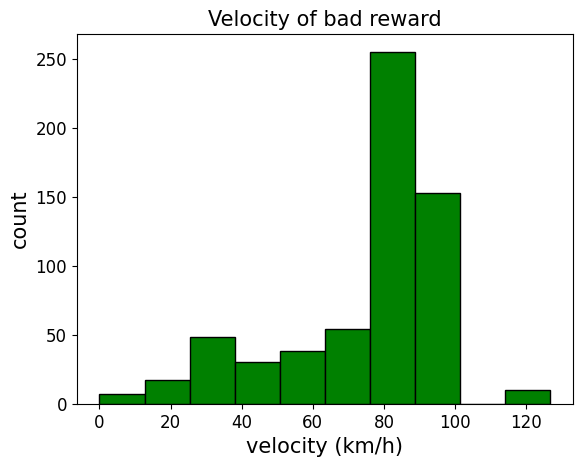

In [25]:
badreward_vel = badreward_vel_1 + badreward_vel_2
plt.hist(badreward_vel, color = 'g', edgecolor='k')
plt.xlabel('velocity (km/h)', fontsize = 15)
plt.ylabel('count', fontsize = 15)
plt.title('Velocity of bad reward', fontsize = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.savefig('Bad reward')

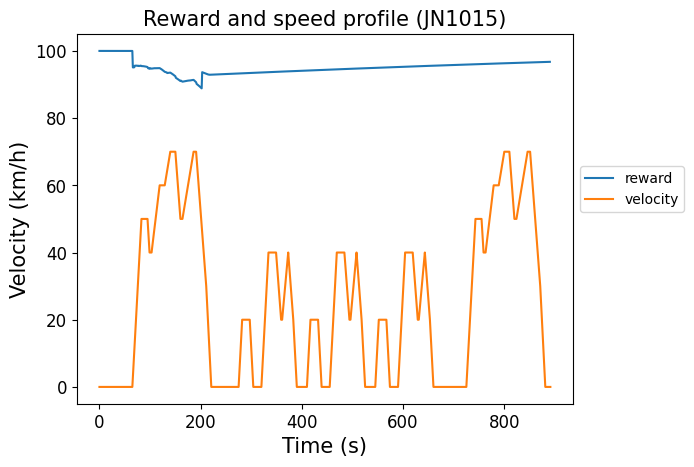

In [ ]:
# WLTP / 766
# HWFET / 766
# JN1015 / 892
# UDDS / 1370
# NEDC / 1181
a = 2
for index in range(1):
  actor = actorlist[index]
  vehicle_speed_profile = cyclelist[a]
  stop_time = stop_time_list[a]
  env = HEV(fmu_filename, start_time, stop_time, step_size, soc_init, vehicle_speed_profile)
  start = time.time()
  # run = wandb.init(project = "cycle anaylsis_",
  #                 config = {"actor":index},
  #                 reinit=True)
  # wandb.run.name = 'SAC'
  state = env.reset()
  episodic_reward = 0
  action1 = []
  action2 = []
  soc = []
  rewardlist = []
  badrewardlist = []
  badrewardtime = []
  step = 0

  while True:
    soc.append(state[0][0])
    state = np.expand_dims(state[0], axis = 0)
    state = tf.convert_to_tensor(state)
    action,_,_ = policy(state, actor)
    next_state, reward, done, info = env.step(action[0])
    # wandb.log({"HWFET":vehicle_speed_profile[step,1]})
    # wandb.log({"HWFET":reward})
    if done:
      break
    rewardlist.append(reward)
    if reward < 0.75:
      badrewardlist.append(reward*100)
      badrewardtime.append(step)
    episodic_reward += reward
    state = next_state
    step +=1

  rewardlist = np.array(rewardlist)*100

plt.plot(rewardlist, color = 'g')
plt.plot(vehicle_speed_profile[:,1], color = 'b')
plt.title('Reward and speed profile (WLTP)', fontsize = 15)
plt.xlabel('Time (s)', fontsize = 15)
plt.ylabel('Velocity (km/h)', fontsize = 15)
plt.scatter(badrewardtime, badrewardlist, color = 'red', label ='bad reward')
plt.legend(['reward', 'velocity', 'bad reward'], loc = 'lower left', bbox_to_anchor=(1.0,0.5))
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
# plt.legend(loc='lower left', bbox_to_anchor=(1.0,0.5))
# plt.grid(True)
plt.grid(True, axis='y', alpha=0.4, linestyle='--')
# plt.savefig("HWFET.png")

  # reward_array[a][index] = episodic_reward
  # print("reward : ", episodic_reward)
  # print("max    : ", len(vehicle_speed_profile))
  # np.save("/content/drive/MyDrive/Colab Notebooks/기계시스템설계/23년/baseline0724/sac/cycle/hwfet/model{}_action1.npy".format(index+1), np.array(action1))
  # np.save("/content/drive/MyDrive/Colab Notebooks/기계시스템설계/23년/baseline0724/sac/cycle/hwfet/model{}_action2.npy".format(index+1), np.array(action2))
  # np.save("/content/drive/MyDrive/Colab Notebooks/기계시스템설계/23년/baseline0724/sac/cycle/hwfet/model{}_soc.npy".format(index+1), np.array(soc))

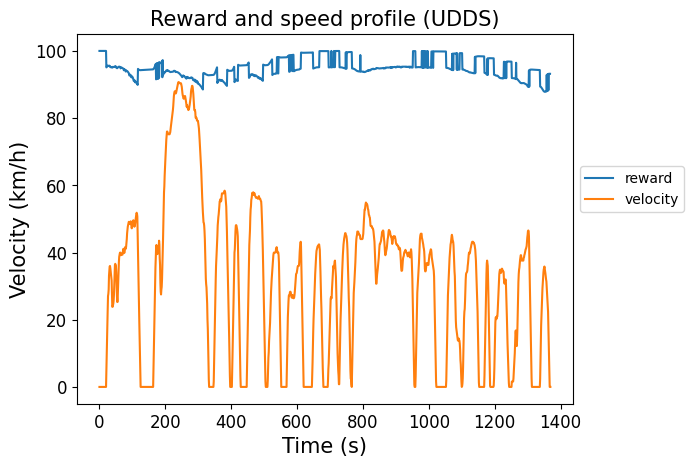

In [ ]:
# WLTP / 766
# HWFET / 766
# JN1015 / 892
# UDDS / 1370
# NEDC / 1181
a = 3
for index in range(1):
  actor = actorlist[index]
  vehicle_speed_profile = cyclelist[a]
  stop_time = stop_time_list[a]
  env = HEV(fmu_filename, start_time, stop_time, step_size, soc_init, vehicle_speed_profile)
  start = time.time()
  # run = wandb.init(project = "cycle anaylsis_",
  #                 config = {"actor":index},
  #                 reinit=True)
  # wandb.run.name = 'SAC'
  state = env.reset()
  episodic_reward = 0
  action1 = []
  action2 = []
  soc = []
  rewardlist = []
  step = 0

  while True:
    soc.append(state[0][0])
    state = np.expand_dims(state[0], axis = 0)
    state = tf.convert_to_tensor(state)
    action,_,_ = policy(state, actor)
    next_state, reward, done, info = env.step(action[0])
    # wandb.log({"HWFET":vehicle_speed_profile[step,1]})
    # wandb.log({"HWFET":reward})
    if done:
      break
    rewardlist.append(reward)
    episodic_reward += reward
    state = next_state
    step +=1

  rewardlist = np.array(rewardlist)*100

plt.plot(rewardlist)
plt.plot(vehicle_speed_profile[:,1])
plt.title('Reward and speed profile (UDDS)', fontsize = 15)
plt.xlabel('Time (s)', fontsize = 15)
plt.ylabel('Velocity (km/h)', fontsize = 15)
plt.legend(['reward', 'velocity'], loc = 'lower left', bbox_to_anchor=(1.0,0.5))
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
# plt.legend(loc='lower left', bbox_to_anchor=(1.0,0.5))

plt.savefig("UDDS.png")

  # reward_array[a][index] = episodic_reward
  # print("reward : ", episodic_reward)
  # print("max    : ", len(vehicle_speed_profile))
  # np.save("/content/drive/MyDrive/Colab Notebooks/기계시스템설계/23년/baseline0724/sac/cycle/hwfet/model{}_action1.npy".format(index+1), np.array(action1))
  # np.save("/content/drive/MyDrive/Colab Notebooks/기계시스템설계/23년/baseline0724/sac/cycle/hwfet/model{}_action2.npy".format(index+1), np.array(action2))
  # np.save("/content/drive/MyDrive/Colab Notebooks/기계시스템설계/23년/baseline0724/sac/cycle/hwfet/model{}_soc.npy".format(index+1), np.array(soc))

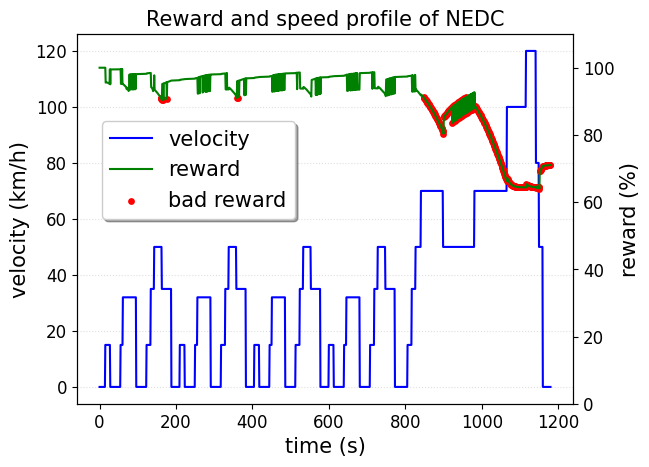

In [ ]:
# WLTP / 766
# HWFET / 766
# JN1015 / 892
# UDDS / 1370
# NEDC / 1181
a = 4
for index in range(1):
  actor = actorlist[index]
  vehicle_speed_profile = cyclelist[a]
  stop_time = stop_time_list[a]
  env = HEV(fmu_filename, start_time, stop_time, step_size, soc_init, vehicle_speed_profile)
  start = time.time()
  # run = wandb.init(project = "cycle anaylsis_",
  #                 config = {"actor":index},
  #                 reinit=True)
  # wandb.run.name = 'SAC'
  state = env.reset()
  episodic_reward = 0
  action1 = []
  action2 = []
  soc = []
  rewardlist = []
  badrewardlist_1 = []
  badrewardtime = []
  badreward_vel_1 = []
  step = 0

  while True:
    soc.append(state[0][0])
    state = np.expand_dims(state[0], axis = 0)
    state = tf.convert_to_tensor(state)
    action,_,_ = policy(state, actor)
    next_state, reward, done, info = env.step(action[0])
    # wandb.log({"HWFET":vehicle_speed_profile[step,1]})
    # wandb.log({"HWFET":reward})
    if done:
      break
    rewardlist.append(reward)
    if reward < 0.912:
      badrewardlist_1.append(reward*100)
      badreward_vel_1.append(vehicle_speed_profile[step,1])
      badrewardtime.append(step)
    episodic_reward += reward
    state = next_state
    step +=1

  rewardlist = np.array(rewardlist)*100

# plt.suptitle("Reward and velocity profile of HWFET")
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax2.plot(rewardlist, 'g', label = 'reward')
ax2.set_ylabel("reward (%)", fontsize = 15)

ax2.set_title("Reward and speed profile of NEDC", fontsize = 15)
ax2.scatter(badrewardtime, badrewardlist_1, color = 'red', label ='bad reward', s = 15)
ax2.set_ylim(0,110)

ax1.plot(vehicle_speed_profile[:,1], color ='b', label ='velocity')
ax1.set_ylabel("velocity (km/h)", fontsize = 15)
ax1.set_xlabel("time (s)", fontsize = 15)
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

ax2.legend(lines + lines2, labels + labels2, loc=(0.05,0.5), fontsize = 15, frameon = True, shadow = True)
ax1.tick_params(axis='x', labelsize=12)  # set xticks font size
ax1.tick_params(axis='y', labelsize=12)  # set yticks font size
ax2.tick_params(axis='y', labelsize=12)

ax1.grid(True, axis='y', alpha=0.4, linestyle=':')
plt.savefig("NEDC.png", bbox_inches='tight')

In [ ]:
# WLTP / 766
a = 0
soc_list = []
for index in range(5):
  actor = actorlist[index]
  vehicle_speed_profile = cyclelist[a]
  stop_time = stop_time_list[a]
  env = HEV(fmu_filename, start_time, stop_time, step_size, soc_init, vehicle_speed_profile)
  start = time.time()
  run = wandb.init(project = "DP & SAC",
                  config = {"actor":index},
                  reinit=True)
  wandb.run.name = 'model {}'.format(index+1)
  state = env.reset()
  episodic_reward = 0

  while True:
    state = np.expand_dims(state[0], axis = 0)
    state = tf.convert_to_tensor(state)
    action,_,_ = policy(state, actor)
    wandb.log({"WLTP SOC":state[0][0]*5000, "WLTP action 1":action[0][0], "WLTP action 2":action[0][1]})
    next_state, reward, done, info = env.step(action[0])
    if done:
      break
    episodic_reward += reward
    state = next_state
  print(episodic_reward)

env.reset()
episodic_reward = 0
run = wandb.init(project = "DP & SAC",
                  config = {"actor":index},
                  reinit=True)
wandb.run.name = 'DP'

s = env.reset()
done = False
step=0
reward=0
while done == False:
  state1, state2 = state_index(s[0][0],s[0][-1])
  action_index = policy_[state1]
  action = action_grid[action_index]
  wandb.log({"WLTP SOC":s[0][0]*5000, "WLTP action 1":action[0], "WLTP action 2":action[1]})
  s,r,done,_ = env.step(action)
  reward += r
print(reward)

1728.2305650897606


WLTP SOC,▂▄▄▄▃▄▃▄▄▃▃▃▂▂▂▃▂▂▂▃▄▄▄▃▂▃▂▄▅▆█▇▆▄▂▁▂▁▂▃
WLTP action 1,▃▅▄▅▄▄▄▄▄▄▃▃▂▂▃▃▂▂▃▃▄▄▄▃▃▃▂▄▅▆█▆▅▄▃▁▂▁▂▃
WLTP action 2,▆▃▃▅▅▄▁▂▂▅▃█▄▃▆▅▆▅▅▄▄▃▃▅▅▄▆▅▄▂▃▃▃▅▅▅▄▅▇▃
WLTP SOC,67.64465
WLTP action 1,-0.00472
WLTP action 2,0.13529


1713.8929126118608


WLTP SOC,▃▅▅▅▄▅▅▆▆▅▅▅▄▄▄▅▄▄▄▄▅▆▅▄▄▄▃▄▅▆███▆▄▂▂▁▁▂
WLTP action 1,▁▆▄▇▂▂▆▄▇▅▂▆▆▄▃▂▄▅▂▂▃▄▅▄▁▅▆▅▆▄▆▆▃▃█▄▇▃▃▅
WLTP action 2,▅▆▁▄▇▅▆▅▆▅▃▃▅▅▆▆█▅▃▄▅▅▆▅▄▃▅▅▆▆█▄▅▄▇▄▄▆▅▅
WLTP SOC,62.28433
WLTP action 1,-0.01853
WLTP action 2,-0.04184


1646.3215853324723


WLTP SOC,▁▂▃▂▃▃▃▄▄▄▄▄▃▃▃▄▄▄▄▄▅▅▅▄▄▄▃▄▅▇███▇▅▄▃▂▂▃
WLTP action 1,█▅▁▆▄▇█▃▆▃▇▅▄▄▅▇▄▆█▃▆▄▅█▅▆▅▄▄▃▇█▆▆▁▁▄▁▄█
WLTP action 2,▅▃▅▄▅▅▆▅▄▄▅▅▅▅█▅▄▁▃▃▄▆▃▃▆▄▇▄▆▄▅▅▄▃▄▆▇▇▇▄
WLTP SOC,73.72246
WLTP action 1,-0.13025
WLTP action 2,-0.07515


1683.4948203306164


WLTP SOC,▁▂▃▂▂▃▃▃▃▃▃▃▂▂▂▃▂▃▃▃▄▄▄▃▃▃▂▄▅▆██▇▆▄▃▃▃▃▄
WLTP action 1,▇▇▅▆▇▅▅▆▆▅▅▆▇▇▄▅▆▄▆▄▆▇▇▅▅▅▂▃▄▅▆▅█▆▃▂▂▁▃▅
WLTP action 2,▂▅▄▃▁▅▄▃▃▄▄▄▂▄▅▅▄▆▂▅▄▂▄▅▄▆▇▇▆▅▁▄▂▁▅▆▇█▇▃
WLTP SOC,76.59555
WLTP action 1,0.02589
WLTP action 2,-0.01146


1694.5162114846785


WLTP SOC,▃▄▄▄▄▅▅▅▆▅▅▅▅▄▄▅▅▅▅▅▆▆▆▅▅▅▃▄▅▆███▇▅▃▃▁▁▂
WLTP action 1,▅▅█▄▅▂▇▇▅▂▃▃▇▅▆▆▇▅▅▂▃▆▂▇▄█▂▁▄▅▂█▇▄▃▅▆▆▃▄
WLTP action 2,▆█▆▄▃▅▂▄▄▄▅▃▄▅▅▅▆▅▃▆▄▄▇▆▄▆▃▃▆▁▅▂▅▅▁▃▅▁▂▅
WLTP SOC,64.34808
WLTP action 1,-0.00303
WLTP action 2,-0.02882


1727.175817182856


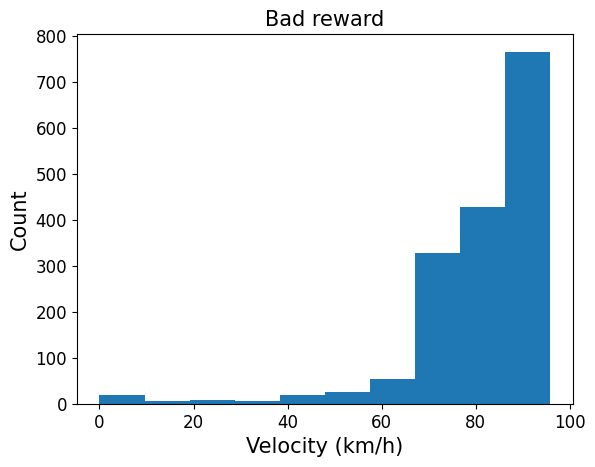

In [ ]:
# plt.scatter(badrewardlist_1, badreward_vel_1)
# plt.scatter(badrewardlist_2, badreward_vel_2)
# plt.scatter(badrewardlist_3, badreward_vel_3)
badreward = badrewardlist_1 + badrewardlist_2 + badrewardlist_3
badreward_vel = badreward_vel_1+badreward_vel_2+badreward_vel_3
plt.hist(badreward_vel)
plt.title("Bad reward", fontsize = 15)
plt.ylabel("Count", fontsize = 15)
plt.xlabel("Velocity (km/h)", fontsize = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.show()

finish


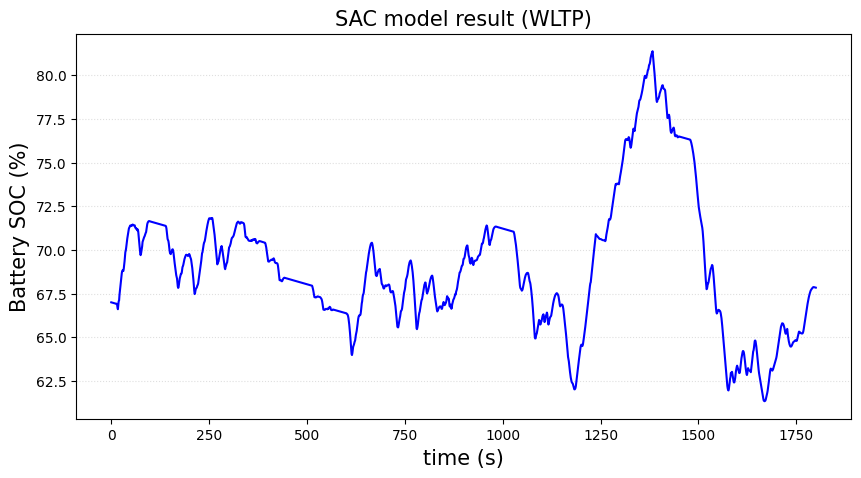

In [ ]:
# WLTP / 766
# HWFET / 766
# JN1015 / 892
# UDDS / 1370
# NEDC / 1181
a = 0
soc_0 = []
for index in range(1):
  actor = actorlist[index]
  vehicle_speed_profile = cyclelist[a]
  stop_time = stop_time_list[a]
  env = HEV(fmu_filename, start_time, stop_time, step_size, soc_init, vehicle_speed_profile)
  start = time.time()
  # run = wandb.init(project = "New test",
  #                 config = {"actor":index},
  #                 reinit=True)
  # wandb.run.name = 'model {}'.format(index+1)
  state = env.reset()
  # episodic_reward = 0
  done = False

  while True:
    soc_0.append(state[0][0]*5000)
    state = np.expand_dims(state[0], axis = 0)
    state = tf.convert_to_tensor(state)
    action,_,_ = policy(state, actor)
    # wandb.log({"WLTP SOC":state[0][0]*5000})
    next_state, reward, done, info = env.step(action[0])
    # soc.append(state[0][0]*5000)
    if done:
      break
    # episodic_reward += reward
    state = next_state

print('finish')
  # reward_array[a][index] = episodic_reward
plt.figure(figsize = (10,5))
plt.plot(soc_0, color ='b')
plt.title('SAC model result (WLTP)', fontsize = 15)
plt.xlabel('time (s)', fontsize = 15)
plt.ylabel('Battery SOC (%)', fontsize = 15)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
# plt.savefig("WLTP.png")
plt.grid(True, axis='y', alpha=0.4, linestyle=':')
# plt.savefig("WLTP.png", bbox_inches='tight')
  # print("reward : ", episodic_reward)
  # print("max    : ", len(vehicle_speed_profile))
  # np.save("/content/drive/MyDrive/Colab Notebooks/기계시스템설계/23년/baseline0724/sac/cycle/wltp/model{}_action1.npy".format(index+1), np.array(action1))
  # np.save("/content/drive/MyDrive/Colab Notebooks/기계시스템설계/23년/baseline0724/sac/cycle/wltp/model{}_action2.npy".format(index+1), np.array(action2))
  # np.save("/content/drive/MyDrive/Colab Notebooks/기계시스템설계/23년/baseline0724/sac/cycle/wltp/model{}_soc.npy".format(index+1), np.array(soc))

finish


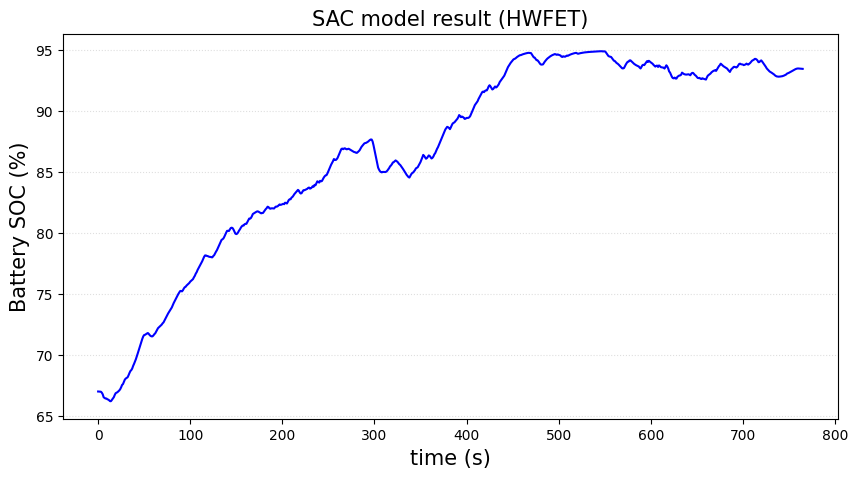

In [ ]:
# WLTP / 766
# HWFET / 766
# JN1015 / 892
# UDDS / 1370
# NEDC / 1181
a = 1
soc_1 = []
for index in range(1):
  actor = actorlist[index]
  vehicle_speed_profile = cyclelist[a]
  stop_time = stop_time_list[a]
  env = HEV(fmu_filename, start_time, stop_time, step_size, soc_init, vehicle_speed_profile)
  start = time.time()
  # run = wandb.init(project = "New test",
  #                 config = {"actor":index},
  #                 reinit=True)
  # wandb.run.name = 'model {}'.format(index+1)
  state = env.reset()
  # episodic_reward = 0
  done = False

  while True:
    soc_1.append(state[0][0]*5000)
    state = np.expand_dims(state[0], axis = 0)
    state = tf.convert_to_tensor(state)
    action,_,_ = policy(state, actor)
    # wandb.log({"WLTP SOC":state[0][0]*5000})
    next_state, reward, done, info = env.step(action[0])
    # soc.append(state[0][0]*5000)
    if done:
      break
    # episodic_reward += reward
    state = next_state

print('finish')
  # reward_array[a][index] = episodic_reward
plt.figure(figsize = (10,5))
plt.plot(soc_1, color ='b')
plt.title('SAC model result (HWFET)', fontsize = 15)
plt.xlabel('time (s)', fontsize = 15)
plt.ylabel('Battery SOC (%)', fontsize = 15)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
# plt.savefig("WLTP.png")
plt.grid(True, axis='y', alpha=0.4, linestyle=':')
# plt.savefig("HWFET.png", bbox_inches='tight')
  # print("reward : ", episodic_reward)
  # print("max    : ", len(vehicle_speed_profile))
  # np.save("/content/drive/MyDrive/Colab Notebooks/기계시스템설계/23년/baseline0724/sac/cycle/wltp/model{}_action1.npy".format(index+1), np.array(action1))
  # np.save("/content/drive/MyDrive/Colab Notebooks/기계시스템설계/23년/baseline0724/sac/cycle/wltp/model{}_action2.npy".format(index+1), np.array(action2))
  # np.save("/content/drive/MyDrive/Colab Notebooks/기계시스템설계/23년/baseline0724/sac/cycle/wltp/model{}_soc.npy".format(index+1), np.array(soc))

finish


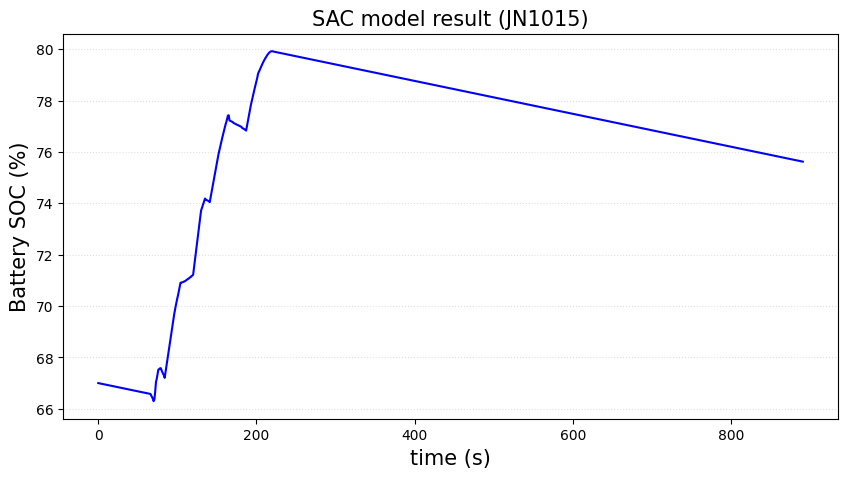

In [ ]:
# WLTP / 766
# HWFET / 766
# JN1015 / 892
# UDDS / 1370
# NEDC / 1181
a = 2
soc_2 = []
for index in range(1):
  actor = actorlist[index]
  vehicle_speed_profile = cyclelist[a]
  stop_time = stop_time_list[a]
  env = HEV(fmu_filename, start_time, stop_time, step_size, soc_init, vehicle_speed_profile)
  start = time.time()
  # run = wandb.init(project = "New test",
  #                 config = {"actor":index},
  #                 reinit=True)
  # wandb.run.name = 'model {}'.format(index+1)
  state = env.reset()
  # episodic_reward = 0
  done = False

  while True:
    soc_2.append(state[0][0]*5000)
    state = np.expand_dims(state[0], axis = 0)
    state = tf.convert_to_tensor(state)
    action,_,_ = policy(state, actor)
    # wandb.log({"WLTP SOC":state[0][0]*5000})
    next_state, reward, done, info = env.step(action[0])
    # soc.append(state[0][0]*5000)
    if done:
      break
    # episodic_reward += reward
    state = next_state

print('finish')
  # reward_array[a][index] = episodic_reward
plt.figure(figsize = (10,5))
plt.plot(soc_2, color ='b')
plt.title('SAC model result (JN1015)', fontsize = 15)
plt.xlabel('time (s)', fontsize = 15)
plt.ylabel('Battery SOC (%)', fontsize = 15)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
# plt.savefig("WLTP.png")
plt.grid(True, axis='y', alpha=0.4, linestyle=':')
# plt.savefig("JN1015.png", bbox_inches='tight')
  # print("reward : ", episodic_reward)
  # print("max    : ", len(vehicle_speed_profile))
  # np.save("/content/drive/MyDrive/Colab Notebooks/기계시스템설계/23년/baseline0724/sac/cycle/wltp/model{}_action1.npy".format(index+1), np.array(action1))
  # np.save("/content/drive/MyDrive/Colab Notebooks/기계시스템설계/23년/baseline0724/sac/cycle/wltp/model{}_action2.npy".format(index+1), np.array(action2))
  # np.save("/content/drive/MyDrive/Colab Notebooks/기계시스템설계/23년/baseline0724/sac/cycle/wltp/model{}_soc.npy".format(index+1), np.array(soc))

finish


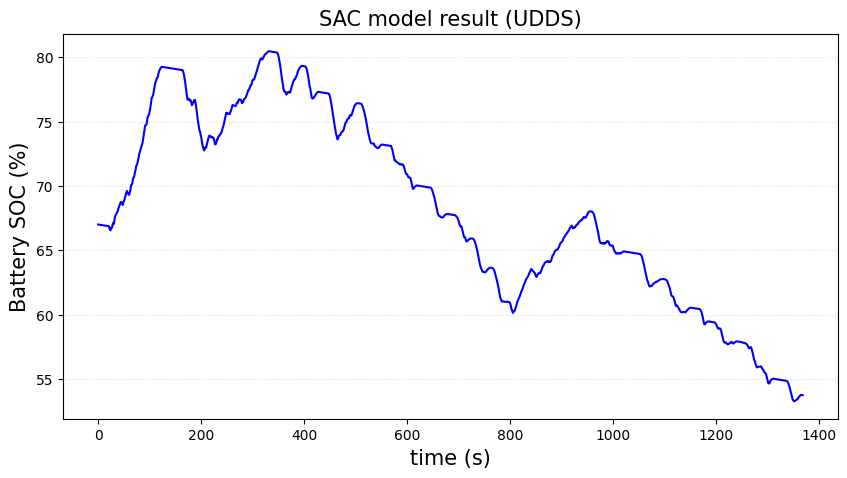

In [ ]:
# WLTP / 766
# HWFET / 766
# JN1015 / 892
# UDDS / 1370
# NEDC / 1181
a = 3
soc_3 = []
for index in range(1):
  actor = actorlist[index]
  vehicle_speed_profile = cyclelist[a]
  stop_time = stop_time_list[a]
  env = HEV(fmu_filename, start_time, stop_time, step_size, soc_init, vehicle_speed_profile)
  start = time.time()
  # run = wandb.init(project = "New test",
  #                 config = {"actor":index},
  #                 reinit=True)
  # wandb.run.name = 'model {}'.format(index+1)
  state = env.reset()
  # episodic_reward = 0
  done = False

  while True:
    soc_3.append(state[0][0]*5000)
    state = np.expand_dims(state[0], axis = 0)
    state = tf.convert_to_tensor(state)
    action,_,_ = policy(state, actor)
    # wandb.log({"WLTP SOC":state[0][0]*5000})
    next_state, reward, done, info = env.step(action[0])
    # soc.append(state[0][0]*5000)
    if done:
      break
    # episodic_reward += reward
    state = next_state

print('finish')
  # reward_array[a][index] = episodic_reward
plt.figure(figsize = (10,5))
plt.plot(soc_3, color ='b')
plt.title('SAC model result (UDDS)', fontsize = 15)
plt.xlabel('time (s)', fontsize = 15)
plt.ylabel('Battery SOC (%)', fontsize = 15)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
# plt.savefig("WLTP.png")
plt.grid(True, axis='y', alpha=0.4, linestyle=':')
# plt.savefig("UDDS.png", bbox_inches='tight')
  # print("reward : ", episodic_reward)
  # print("max    : ", len(vehicle_speed_profile))
  # np.save("/content/drive/MyDrive/Colab Notebooks/기계시스템설계/23년/baseline0724/sac/cycle/wltp/model{}_action1.npy".format(index+1), np.array(action1))
  # np.save("/content/drive/MyDrive/Colab Notebooks/기계시스템설계/23년/baseline0724/sac/cycle/wltp/model{}_action2.npy".format(index+1), np.array(action2))
  # np.save("/content/drive/MyDrive/Colab Notebooks/기계시스템설계/23년/baseline0724/sac/cycle/wltp/model{}_soc.npy".format(index+1), np.array(soc))

finish


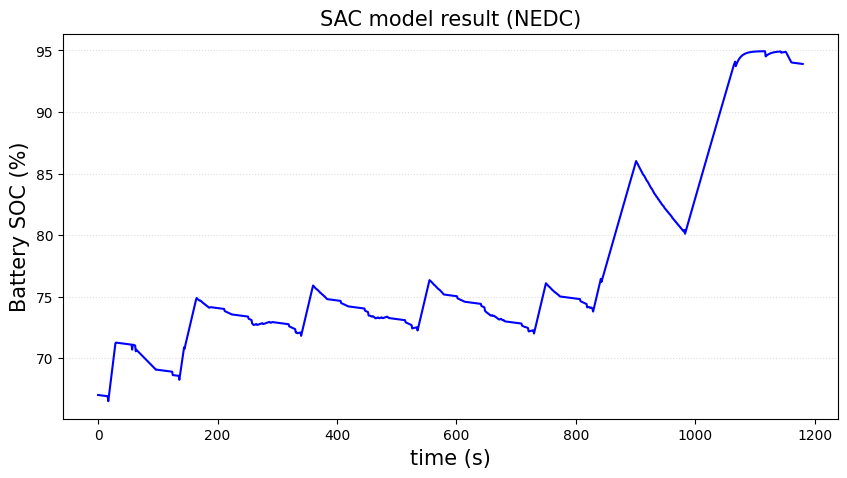

In [ ]:
# WLTP / 766
# HWFET / 766
# JN1015 / 892
# UDDS / 1370
# NEDC / 1181
a = 4
soc_4 = []
for index in range(1):
  actor = actorlist[index]
  vehicle_speed_profile = cyclelist[a]
  stop_time = stop_time_list[a]
  env = HEV(fmu_filename, start_time, stop_time, step_size, soc_init, vehicle_speed_profile)
  start = time.time()
  # run = wandb.init(project = "New test",
  #                 config = {"actor":index},
  #                 reinit=True)
  # wandb.run.name = 'model {}'.format(index+1)
  state = env.reset()
  # episodic_reward = 0
  done = False

  while True:
    soc_4.append(state[0][0]*5000)
    state = np.expand_dims(state[0], axis = 0)
    state = tf.convert_to_tensor(state)
    action,_,_ = policy(state, actor)
    # wandb.log({"WLTP SOC":state[0][0]*5000})
    next_state, reward, done, info = env.step(action[0])
    # soc.append(state[0][0]*5000)
    if done:
      break
    # episodic_reward += reward
    state = next_state

print('finish')
  # reward_array[a][index] = episodic_reward
plt.figure(figsize = (10,5))
plt.plot(soc_4, color ='b')
plt.title('SAC model result (NEDC)', fontsize = 15)
plt.xlabel('time (s)', fontsize = 15)
plt.ylabel('Battery SOC (%)', fontsize = 15)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
# plt.savefig("WLTP.png")
plt.grid(True, axis='y', alpha=0.4, linestyle=':')
# plt.savefig("NEDC.png", bbox_inches='tight')
  # print("reward : ", episodic_reward)
  # print("max    : ", len(vehicle_speed_profile))
  # np.save("/content/drive/MyDrive/Colab Notebooks/기계시스템설계/23년/baseline0724/sac/cycle/wltp/model{}_action1.npy".format(index+1), np.array(action1))
  # np.save("/content/drive/MyDrive/Colab Notebooks/기계시스템설계/23년/baseline0724/sac/cycle/wltp/model{}_action2.npy".format(index+1), np.array(action2))
  # np.save("/content/drive/MyDrive/Colab Notebooks/기계시스템설계/23년/baseline0724/sac/cycle/wltp/model{}_soc.npy".format(index+1), np.array(soc))

In [ ]:
plt.s

[67.0,
 66.99366083490155,
 66.9872576378324,
 66.98085444076325,
 66.9744512436941,
 66.96804804662496,
 66.96164484955581,
 66.95524165248666,
 66.94883845541752,
 66.94243525834837,
 66.93603206127922,
 66.92962886421007,
 66.92322566714093,
 66.91646433750607,
 66.92271250727819,
 66.85509684456044,
 66.6916399644375,
 66.60562908389272,
 66.82401162216266,
 67.06827851448419,
 67.09983854121076,
 67.41745227223545,
 67.63722989989837,
 67.87793667344452,
 68.10493049252277,
 68.3468061801991,
 68.48346037138906,
 68.68279078154828,
 68.78005814778558,
 68.83271605370828,
 68.79512752909216,
 68.79834505385702,
 68.93984681145254,
 69.12971519161663,
 69.3486311758428,
 69.58619058076997,
 69.87331572819816,
 69.9539683625346,
 70.10453221414578,
 70.30440211835372,
 70.49408078562735,
 70.65667824232058,
 70.80559477196881,
 70.96344343502174,
 71.10315605332461,
 71.21405382328817,
 71.2783020487548,
 71.30894634758985,
 71.38051015281214,
 71.40056787558494,
 71.40138799813755,


In [ ]:
ep_reward_list = np.load("eprewardlist.npy")
total = [766.6, 892, 1370, 1181, 1800]
indexlist = [-1,0,1,2,3]
ep_reward = np.zeros((5,5))
for i in range(len(ep_reward)):
  ep_reward[i] = ep_reward_list[indexlist[i]]/total[indexlist[i]]
ep_reward

array([[0.96594444, 0.96516667, 0.96511111, 0.9625    , 0.96241667],
       [0.77282056, 0.78049994, 0.75488905, 0.74186915, 0.75649191],
       [0.95051661, 0.96064172, 0.96452572, 0.95474542, 0.96310233],
       [0.94779017, 0.94157201, 0.93867242, 0.93870976, 0.94200396],
       [0.91197196, 0.84470394, 0.70914054, 0.7340953 , 0.71755701]])

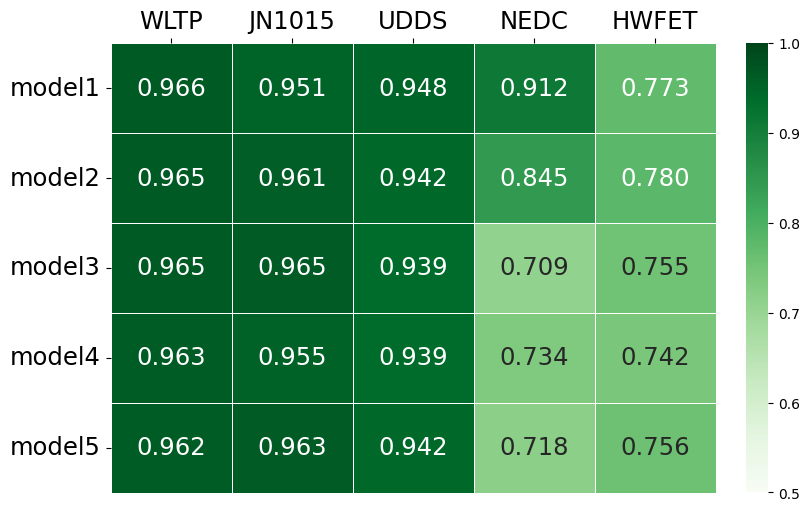

In [ ]:
import pandas as pd
import seaborn as sns

hello = {'WLTP': ep_reward[0],
 'JN1015':ep_reward[2],
 'UDDS':ep_reward[3],
 'NEDC':ep_reward[-1],
 'HWFET':ep_reward[1]
}
df = pd.DataFrame(hello)
# df
df= df.set_axis(labels = ['model1', 'model2','model3','model4','model5'])
# df = df.T

# plt.pcolor(df)
fig, ax = plt.subplots(1,1,figsize = (8,5),sharey = True,constrained_layout=True)
# plt.subplots_adjust(hspace = 0.35)

# plt.figure(figsize=(8,5))
sns.heatmap(df, vmin = 0.5, vmax = 1, annot = True, linewidth = 0.5, fmt = '.3f', annot_kws = {"size":17.5}, cmap ='Greens')
ax.xaxis.tick_top()
# fig.suptitle('Total reward of SAC models', fontsize = 20)
# plt.xlabel('cycle', fontsize = 15)
# plt.ylabel('model', fontsize = 15, rotation = 0)
plt.xticks(fontsize =17.5, rotation = 0)
plt.yticks(fontsize =17.5, rotation = 0)
# plt.title("Total reward of SAC models", fontsize = 15)

# df.style.background_gradient(cmap='summer')
plt.savefig('SAC.png')

In [ ]:
import numpy as np
import wandb
cycle_name = ["HWFET", "JN1015", "UDDS","NEDC", "WLTP"]
ep_reward_list = np.load("eprewardlist.npy")

for i in range(ep_reward_list.shape[0]):
  run = wandb.init(project = "Cycle test",
                  reinit=True)
  wandb.run.name = cycle_name[i]
  for j in range(ep_reward_list.shape[1]):
    wandb.log({ "Step": j+1,"Episodic reward": ep_reward_list[i,j]})

wandb: Currently logged in as: yoonlouis. Use `wandb login --relogin` to force relogin


Episodic reward,▇█▃▁▄
Step,▁▃▅▆█
Episodic reward,579.9267
Step,5


Episodic reward,▁▆█▃▇
Step,▁▃▅▆█
Episodic reward,859.08728
Step,5


Episodic reward,█▃▁▁▄
Step,▁▃▅▆█
Episodic reward,1290.54543
Step,5


Episodic reward,█▆▁▂▁
Step,▁▃▅▆█
Episodic reward,847.43483
Step,5


In [ ]:
hello = np.r_[reward_array, [[1738.7, 1737.3, 1737.2, 1732.5, 1732.35]]]